# Test klasyfikacji

In [1]:
import numpy as np
from library.audio_extract_param import read_feature
import library.vision_utils as vu

In [2]:
# Load data
datasets = read_feature('./data/datasets/mfccs_feature/mfccs_13.pkl')
data   = datasets['data']
target = datasets['target']
file   = datasets['file']

classes   = [c.replace('Sound_','') for c in np.unique(target)]
n_classes = len(classes)

In [3]:
from sklearn import metrics
import time

def classifier_test(classifier_model, X_train, X_test, y_train, y_test, return_time = False):
    # Uczenie modelu
    start_learn = time.time()
    classifier_model.fit(X_train, y_train)
    t_learn = time.time() - start_learn
    
    # Predykcja
    start_pred = time.time()
    y_pred = classifier_model.predict(X_test)
    t_pred = time.time() - start_pred
    
    # Jakość klasyfikacji
    acc = metrics.accuracy_score(y_test, y_pred)

    # Macierz pomyłek
    cm = metrics.confusion_matrix(y_test, y_pred, labels=classifier_model.classes_, normalize='true')

    if not return_time:
        return acc, cm

    return acc, cm, t_learn, t_pred

In [4]:
# Import all required classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

TEST_SIZE = [0.2, 0.3, 0.4] # Testing `test_size` parameter
N_ITER = 50                 # Number of iterations for all tests

# Classifiers
K_NEIGHBORS = [1,3,5,7,13]
CLASSIFIERS = [
    GaussianNB(), 
    LinearDiscriminantAnalysis(), 
    QuadraticDiscriminantAnalysis(),
    NearestCentroid(),
    SVC(),
    RandomForestClassifier(10, max_depth=20, n_jobs=-1, random_state=0),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[0]),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[1]),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[2]),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[3]),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[4]),
    ]

CLASSIFIERS_DOCSTR = [
    "Gaussian NB",
    "Linear Discriminant Analysis",
    "Quadratic Discriminant Analysis",
    "Nearest Centroid",
    "SVC",
    "RandomForestClassifier",
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[0]),
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[1]),
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[2]),
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[3]),
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[4]),
]

In [5]:
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Generate random seeds for shuffle
SEEDS = np.random.randint(1e6, size=(N_ITER))

# Memory allocation
accuracy_matrix  = np.zeros( ( len(TEST_SIZE), len(CLASSIFIERS) ) )
confusion_matrix = np.zeros( ( len(TEST_SIZE), len(CLASSIFIERS), n_classes, n_classes ) )
training_time_matrix   = np.zeros( ( len(TEST_SIZE), len(CLASSIFIERS) ) )
prediction_time_matrix = np.zeros( ( len(TEST_SIZE), len(CLASSIFIERS) ) )


# --- CLASSIFIER TESTS ---

# For each classifiers 
for j, classifier in enumerate(CLASSIFIERS):
    print("Test klasyfikatora {}:".format(CLASSIFIERS_DOCSTR[j]))

    # For each test size
    p_bar = tqdm(TEST_SIZE)
    for i, t_size in enumerate(p_bar):
        p_bar.set_description('{: <16}'.format('Test Size: {}'.format(t_size)))
        

        # For each iteration
        for seed in SEEDS:
            # Shuffle and roll test size
            X_train, X_test, y_train, y_test = train_test_split(data, target,           
                                                                test_size=t_size, random_state=seed)

            accuracy, confusion, t_learn, t_pred = classifier_test(classifier, X_train, X_test, y_train, y_test, True)

            # Adding evaluation statistics
            accuracy_matrix[i,j]        += accuracy
            confusion_matrix[i,j,:,:]   += confusion
            training_time_matrix[i,j]   += t_learn
            prediction_time_matrix[i,j] += t_pred

        p_bar.set_description('')
            
    
# Normalize evaluation statistics
accuracy_matrix         /= N_ITER
training_time_matrix    /= N_ITER
prediction_time_matrix  /= N_ITER

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        confusion_matrix[i,j,:,:] = confusion_matrix[i,j,:,:] / N_ITER   

Test klasyfikatora Gaussian NB:


100%|██████████| 5/5 [00:00<00:00, 53.70it/s]          


Test klasyfikatora Linear Discriminant Analysis:


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]                  


Test klasyfikatora Quadratic Discriminant Analysis:


100%|██████████| 5/5 [00:00<00:00,  7.50it/s]                  


Test klasyfikatora Nearest Centroid:


100%|██████████| 5/5 [00:00<00:00, 39.00it/s]          


Test klasyfikatora SVC:


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]                  


Test klasyfikatora RandomForestClassifier:


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]                  


Test klasyfikatora KNeighbors Classifier kNN=1:


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]                  


Test klasyfikatora KNeighbors Classifier kNN=3:


100%|██████████| 5/5 [00:00<00:00,  9.40it/s]                  


Test klasyfikatora KNeighbors Classifier kNN=5:


100%|██████████| 5/5 [00:00<00:00,  8.82it/s]                  


Test klasyfikatora KNeighbors Classifier kNN=7:


100%|██████████| 5/5 [00:00<00:00,  9.11it/s]                  


Test klasyfikatora KNeighbors Classifier kNN=13:


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]                  


## Reprezentacja wyników
---

### Wykres dokładności klasyfikatorów

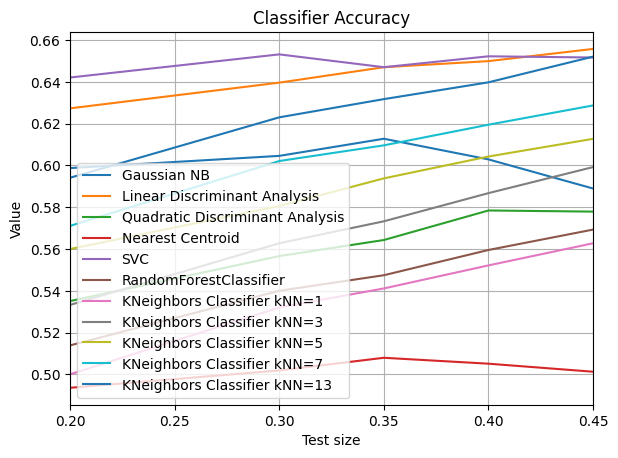

In [9]:
vu.display_classifiers_statistics(CLASSIFIERS_DOCSTR,
                                  TEST_SIZE,
                                  accuracy_matrix,
                                  "Classifier Accuracy")

### Czas uczenia klasyfikatora

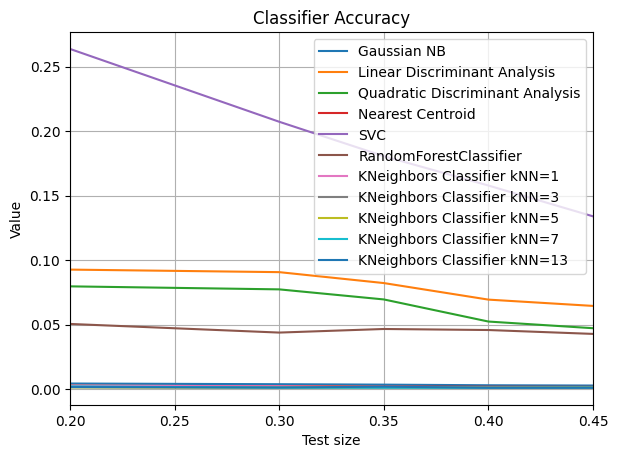

In [10]:
vu.display_classifiers_statistics(CLASSIFIERS_DOCSTR,
                                  TEST_SIZE,
                                  training_time_matrix,
                                  "Classifier Accuracy")

### Czas predykcji

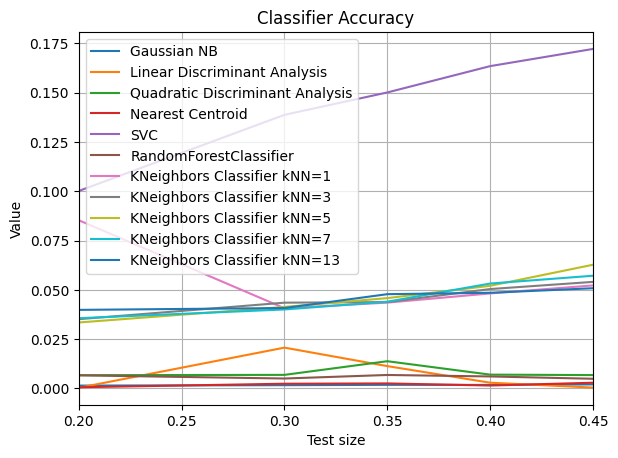

In [11]:
vu.display_classifiers_statistics(CLASSIFIERS_DOCSTR,
                                  TEST_SIZE,
                                  prediction_time_matrix,
                                  "Classifier Accuracy")

### Macierz pomyłek

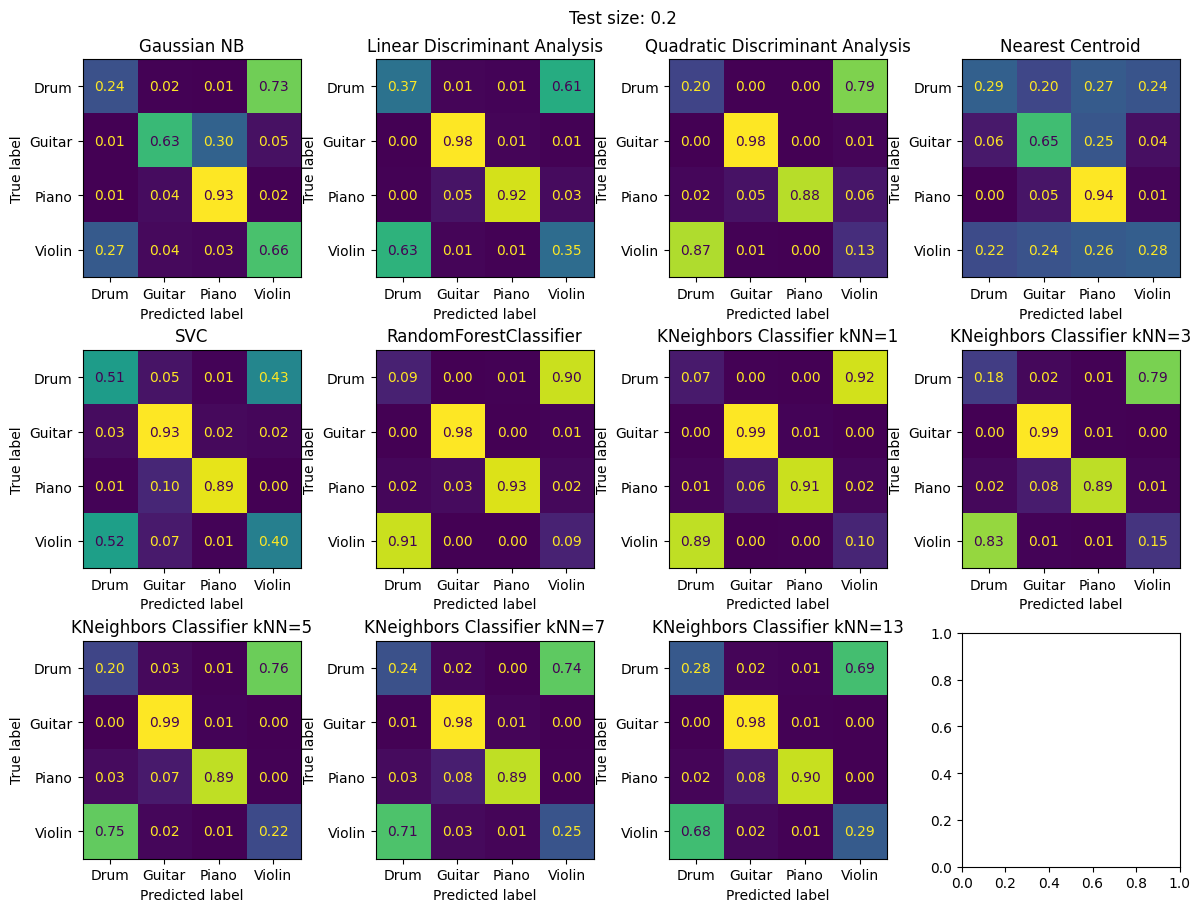

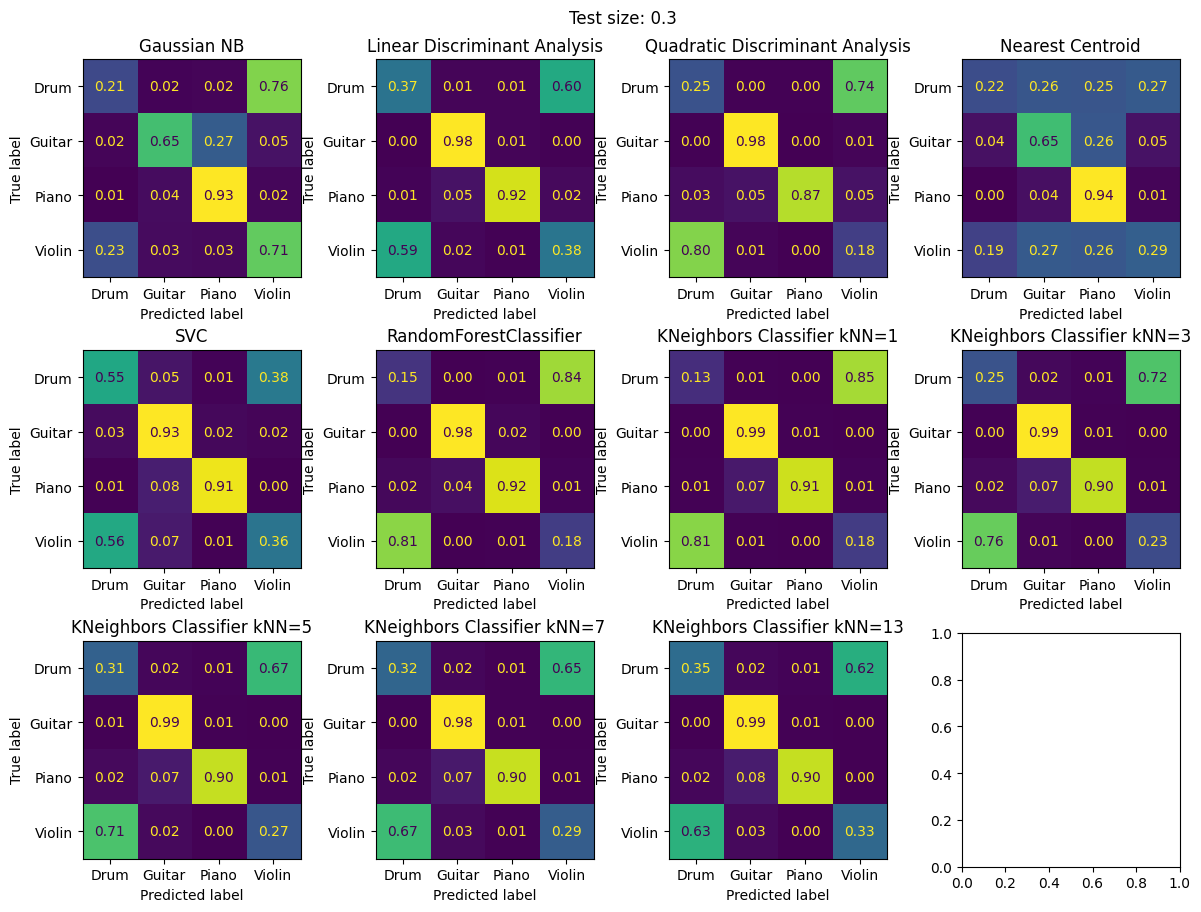

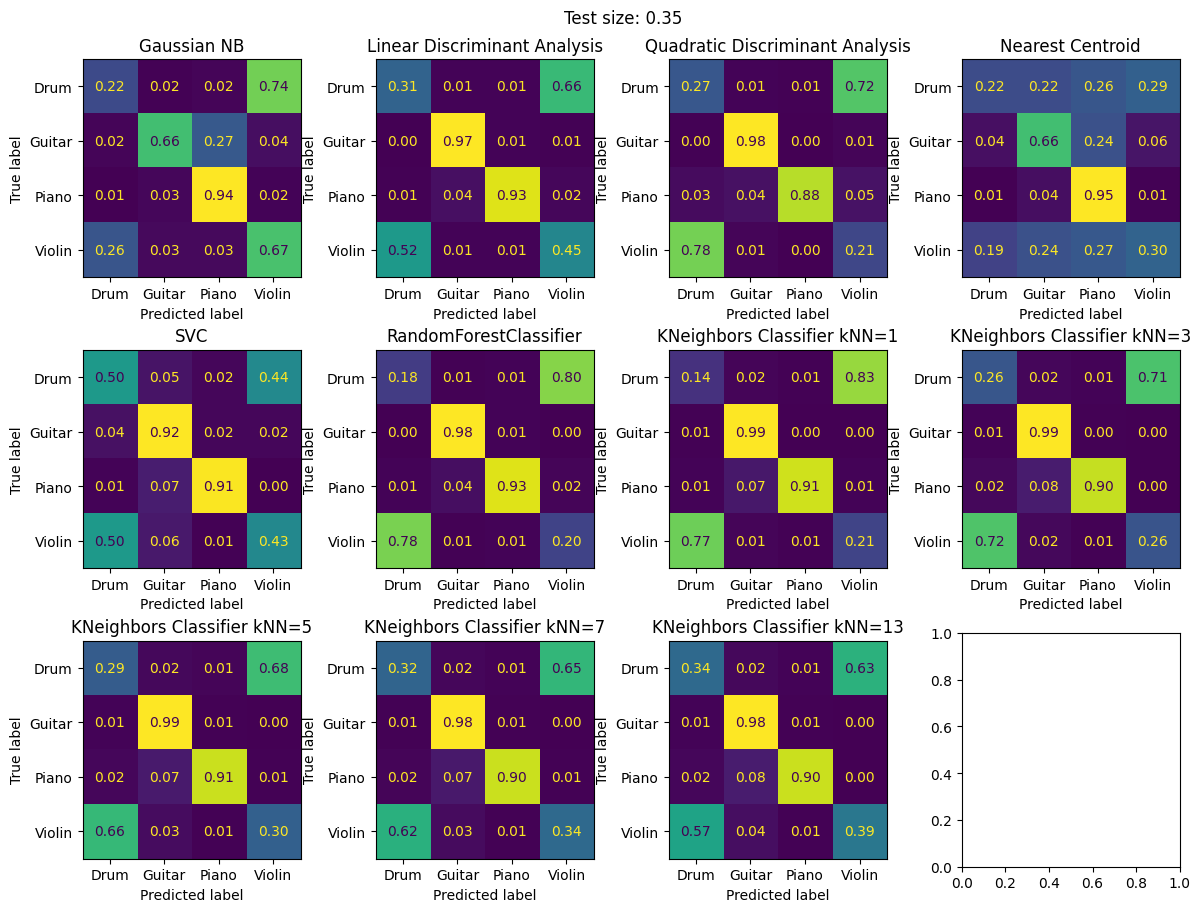

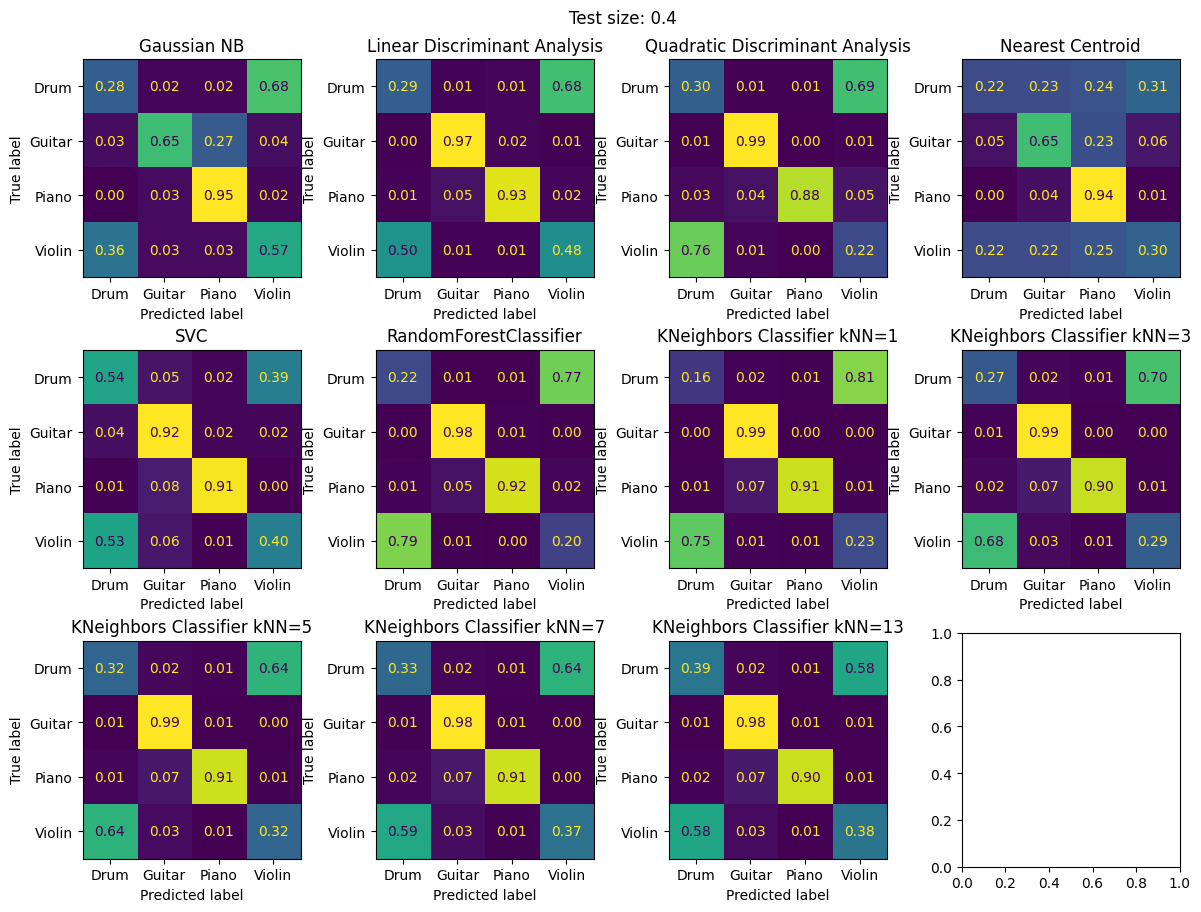

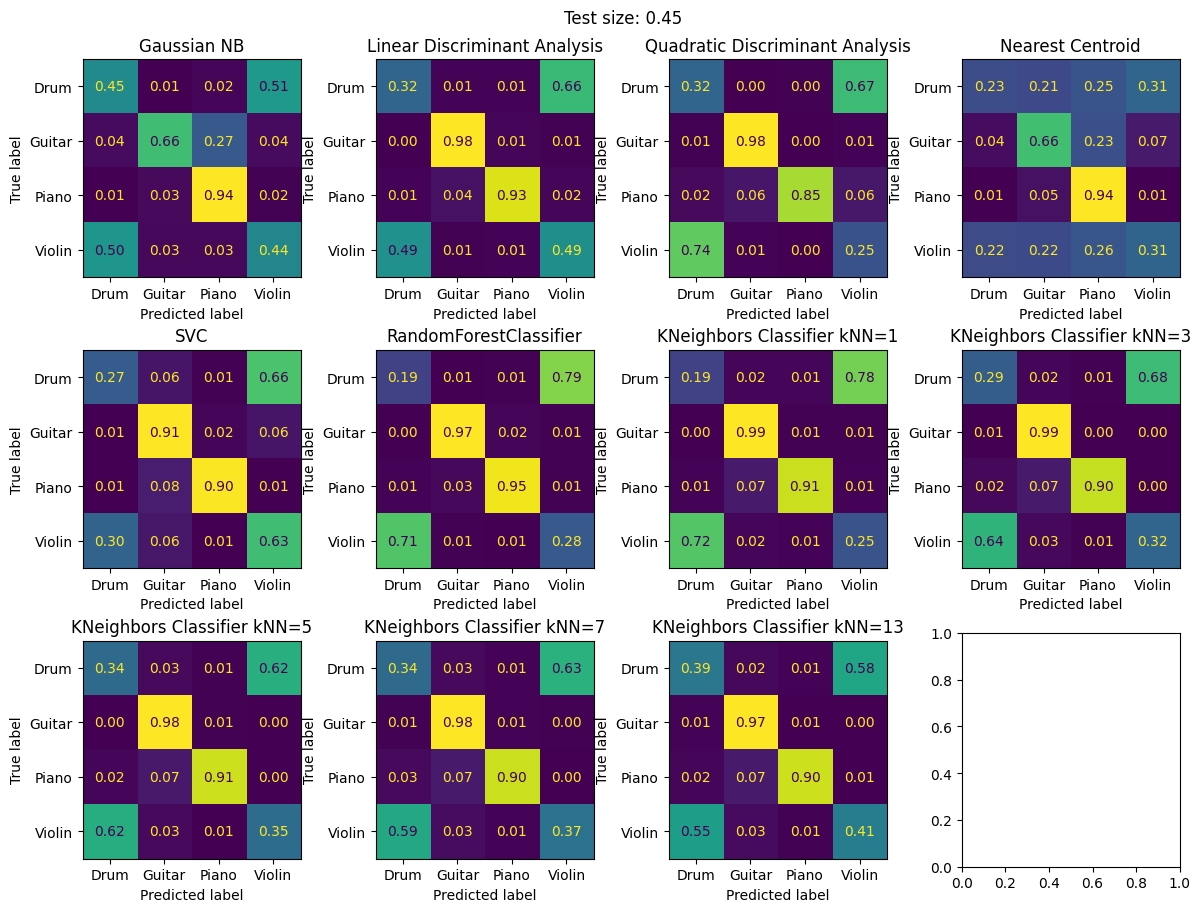

In [10]:
display_test_size = TEST_SIZE

vu.display_classifiers_confusion_matrix(CLASSIFIERS_DOCSTR,
classes, confusion_matrix, TEST_SIZE, display_test_size)